# 【問題1】機械翻訳の実行とコードリーディング

Keras公式のサンプルコードで、短い英語からフランス語への変換が行えるのでこれを動かしてください。

[keras/lstm_seq2seq.py at master · keras-team/keras](https://github.com/keras-team/keras/blob/master/examples/lstm_seq2seq.py)

その上でこのサンプルコードの各部分がどういった役割かを読み取り、まとめてください。以下のようにどこからどこの行が何をしているかを記述してください。

（例）

51から55行目 : ライブラリのimport
57から62行目 : ハイパーパラメータの設定

In [0]:
# Google ドライブをマウントするには、このセルを実行してください。
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
lines[0]

'Go.\tVa !'

In [0]:
# ライブラリのインポート
from __future__ import print_function
from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np

#各種パラメータの設定
batch_size = 64  
epochs = 100  
latent_dim = 256 
num_samples = 10000 
data_path = 'drive/My Drive/DIC/sprint25/fra-eng/fra.txt'


input_texts = []
target_texts = []
input_characters = set()
target_characters = set()

#言語データを開いて、変数に格納
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
#1行ずつ呼び出して、input, targetのリストに分ける。
#更に行を単語ごとに分割して、input_characters, target_charactersへ格納する。
# \tは始まりの合図、\nは終わりの合図
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text = line.split('\t')
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

#各種リストの並び替えや、変数の格納
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

#表示
print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

#input,targetのトークン化(それぞれの単語にidを割り当てる。)
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

#入れ物を用意
#encoderの入力データ,shape(入力データ数, 入力データの最大単語数, 入力データの単語数)
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32') 
    
#decoderの入力データ shape(入力データ数, 入力データの最大単語数, 入力データの単語数)
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32') 
    
#decoderの出力データ shape(入力データ数, 入力データの最大単語数, 入力データの単語数)
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

#入れ物にワンホットラベル化して入れる
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

#モデルビルディング(encoder)
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]

#モデルビルディング(decoder)
decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states) #initial_stateでencoder_statesを受け取る。
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

#encoder,decoderを混ぜてモデル作成。
#encoder, decoderのインプットが入力データ、decoder_outputsが教師データ
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)
model.save('s2s.h5')

#推論のモデルを作成
#encoderのinputが入力データ、encoderのstatesを教師データとする。
encoder_model = Model(encoder_inputs, encoder_states)

#decoderはencoderのpredictをstatesとして、target_sequenceをinputとしてpredectするようなモデルを作る。
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs) #decoder_inputを入力データ、initial_stateにdecoder_states_inputを渡す。
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

#予測値はワンホットベクトル化されているので、言語に戻す。
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())


#predictする関数の作成
def decode_sequence(input_seq):
    #encoderで予測
    states_value = encoder_model.predict(input_seq)
    
    #decoderに入力するベクトルの作成(最初はスタートindex)
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, target_token_index['\t']] = 1.
    
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        
        #decoderで予測(inputは\t or 自分の予測値, statesはencoder_predict or decoder_states)
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)
        
        #softmaxからの変換や、idから言語への変換等
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char
        
        #終わりの合図or限界が来たらfor文停止、
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True
            
        #encoderの予測値をtarget_seqに入れ、statesも更新して、while文をまた回す。
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.
        states_value = [h, c]

    return decoded_sentence


#100個のサンプル文章を推論している。
for seq_index in range(100):
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

Number of samples: 10000
Number of unique input tokens: 70
Number of unique output tokens: 93
Max sequence length for inputs: 16
Max sequence length for outputs: 59


W0628 03:53:12.878851 139788347021184 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0628 03:53:12.914463 139788347021184 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0628 03:53:12.932266 139788347021184 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0628 03:53:13.523302 139788347021184 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0628 03:53:13.657705 139788347021184 deprecation_wrappe

Train on 8000 samples, validate on 2000 samples
Epoch 1/100
8000/8000 [==============================] - 17s 2ms/step - loss: 0.9169 - val_loss: 0.9398
Epoch 2/100
8000/8000 [==============================] - 12s 2ms/step - loss: 0.7275 - val_loss: 0.7567
Epoch 3/100
8000/8000 [==============================] - 12s 2ms/step - loss: 0.6179 - val_loss: 0.6745
Epoch 4/100
8000/8000 [==============================] - 12s 2ms/step - loss: 0.5626 - val_loss: 0.6367
Epoch 5/100
8000/8000 [==============================] - 12s 2ms/step - loss: 0.5244 - val_loss: 0.5879
Epoch 6/100
8000/8000 [==============================] - 12s 2ms/step - loss: 0.4931 - val_loss: 0.5664
Epoch 7/100
8000/8000 [==============================] - 13s 2ms/step - loss: 0.4672 - val_loss: 0.5467
Epoch 8/100
8000/8000 [==============================] - 12s 2ms/step - loss: 0.4461 - val_loss: 0.5282
Epoch 9/100
8000/8000 [==============================] - 12s 2ms/step - loss: 0.4247 - val_loss: 0.5176
Epoch 10/100
800

/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_1/while/Exit_2:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'lstm_1/while/Exit_3:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


-
Input sentence: Go.
Decoded sentence: Va !

-
Input sentence: Hi.
Decoded sentence: Salut !

-
Input sentence: Run!
Decoded sentence: Courez !

-
Input sentence: Run!
Decoded sentence: Courez !

-
Input sentence: Who?
Decoded sentence: Qui ?

-
Input sentence: Wow!
Decoded sentence: Ça alors !

-
Input sentence: Fire!
Decoded sentence: Au feu !

-
Input sentence: Help!
Decoded sentence: À l'aide !

-
Input sentence: Jump.
Decoded sentence: Saute.

-
Input sentence: Stop!
Decoded sentence: Ça suffit !

-
Input sentence: Stop!
Decoded sentence: Ça suffit !

-
Input sentence: Stop!
Decoded sentence: Ça suffit !

-
Input sentence: Wait!
Decoded sentence: Attendez !

-
Input sentence: Wait!
Decoded sentence: Attendez !

-
Input sentence: Go on.
Decoded sentence: Poursuis.

-
Input sentence: Go on.
Decoded sentence: Poursuis.

-
Input sentence: Go on.
Decoded sentence: Poursuis.

-
Input sentence: Hello!
Decoded sentence: Bonjour !

-
Input sentence: Hello!
Decoded sentence: Bonjour !

-
I

`イメージキャプショニング`  

他の活用例としてイメージキャプショニングがあります。  
画像に対する説明の文章を推定するタスクです。これは画像を入力し、時系列を出力するImage to Sequenceの手法によって行えます。

pytorch-tutorial/tutorials/03-advanced/image_captioning at master · yunjey/pytorch-tutorial

イメージキャプショニングは学習に多くの時間がかかるため、ここでは学習済みの重みが公開されている実装を動かすことにします。Kerasには平易に扱える実装が公開されていないため、今回はPyTorchによる実装を扱います。

In [2]:
%cd pytorch-tutorial/tutorials/03-advanced/image_captioning/

/Users/takahashiakira/Documents/DIC/diveintocode-ml/term2/sprint25/pytorch-tutorial/tutorials/03-advanced/image_captioning


In [8]:
!models/pretrained_model/decoder-5-3000.pkl

README.md        data_loader.py   png              sample.py
__pycache__      download.sh      pycocotools      train.py
build_vocab.py   model.py         requirements.txt
data             models           resize.py


<start> a woman and a woman are sitting on a bed . <end>


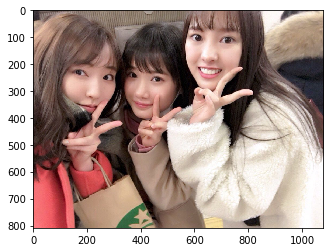

In [21]:
%run sample.py --image='../../../../../../../../../Pictures/壁紙/モーニング娘。/775cc23073128fdc2ab49d2cc2d3efe65b130b75.11.2.9.2.jpeg' \
--encoder_path=models/pretrained_model/encoder-5-3000.pkl \
--decoder_path=models/pretrained_model/decoder-5-3000.pkl

<start> a group of people sitting around a table with a cake . <end>


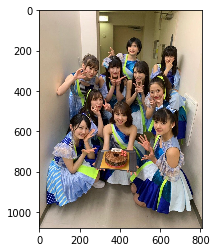

In [20]:
%run sample.py --image='../../../../../../../../../Pictures/壁紙/モーニング娘。/8ccd08a19711141d2c18b9681807d3c53775dc52.11.2.9.2.jpeg' \
--encoder_path=models/pretrained_model/encoder-5-3000.pkl \
--decoder_path=models/pretrained_model/decoder-5-3000.pkl

# 【問題3】Kerasで動かしたい場合はどうするかを調査

**PytorchによるモデルをKerasで動かす方法**
1. PytorchによるモデルのアーキテクチャをKerasで再構築する。（レイヤーは１対１対応する）  
    - 入力、出力の形状を揃える  
    - カーネルサイズを揃える
    - ストライド、パディングの方法を揃える

1. Kerasで再構築したモデルの各レイヤーに対して、Pytorchのレイヤーの重みを共有する。

    - Pytorchのモデルに対して.state_dict()メソッドを適用し、各レイヤーの重みを抽出する。
        - アウトプットのデータ型は"pythonの辞書型"であり、keyはレイヤーの名称、valueは重みである。
    - Kerasのlayer.set_weights(weights)メソッドを用いて、Pytorchのモデルから抽出した重みを代入していく。注意点は以下の通り。
        - 重みを格納した辞書のkeyであるレイヤーの名称を、KerasとPytorchで揃えること。
        - Pytorchモデルで取得した重みのデータ型を、Pytorchの.numpy()メソッドでNumpy配列に変換すること。 （Pytorchから取得した重みの型はTensorに対して、set_weights()メソッドでkerasモデルに代入する重みの型はNumpyである必要がある）